# <span style ="color:royalblue"> <center> **Miniproyecto 1** </center> </span>

En este Jupyter Notebook pueden implementar los códigos necesarios para resolver el **Miniproyecto 1**.

**Importante:** Recuerden que, como grupo, deben **adjuntar el código** en su entrega. En caso de que desarrollen parte del trabajo en este notebook pero **no lo incluyan en la entrega**, **toda la sección de calificación correspondiente al código será evaluada con cero**.

Tengan en cuenta que Coursera utiliza recursos compartidos entre todos los grupos, por lo tanto, si hay muchos equipos trabajando al mismo tiempo, los procesos pueden demorar más de lo previsto.

Pueden agregar todas las celdas de código que consideren necesarias para resolver el miniproyecto. **No hay un límite en este aspecto.**


Algunas instalaciones necesarias para poder generar el notebook desde el espacio código miniproyecto 1 de Coursera...

In [1]:
! pip install kagglehub


[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
! pip install pydot
! pip install graphviz


[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


## Análisis Exploratorio de Datos

In [3]:
import numpy as np
import tensorflow as tf
import random
import os
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [4]:
# Imports necesarios para traer la data de Kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1


In [5]:
# Directorio temporal de datos
import os

data_dir = "/root/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1"
print(os.listdir(data_dir))


['pituitary', 'meningioma', 'healthy', 'glioma']


Al hacer print al directorio se puede observar que el `data_dir` tiene 4 sub carpetas conteniendo los datos:
1. Pituitaria
2. Meningioma
3. Saludable
4. Glioma

Dentro de cada una están las imagenes a tratar y se exploran a continuación:

Mismas clases anteriormente encontradas: ['pituitary', 'meningioma', 'healthy', 'glioma']
pituitary: 1757 imágenes
  Ejemplos: ['0899.jpg', '0848.jpg', '1743.jpg']

meningioma: 1645 imágenes
  Ejemplos: ['1617.jpg', '0057.jpg', '0391.jpg']

healthy: 2000 imágenes
  Ejemplos: ['0848.jpg', '0899.jpg', '0675.jpg']

glioma: 1621 imágenes
  Ejemplos: ['1279.jpg', '0439.jpg', '0058.jpg']



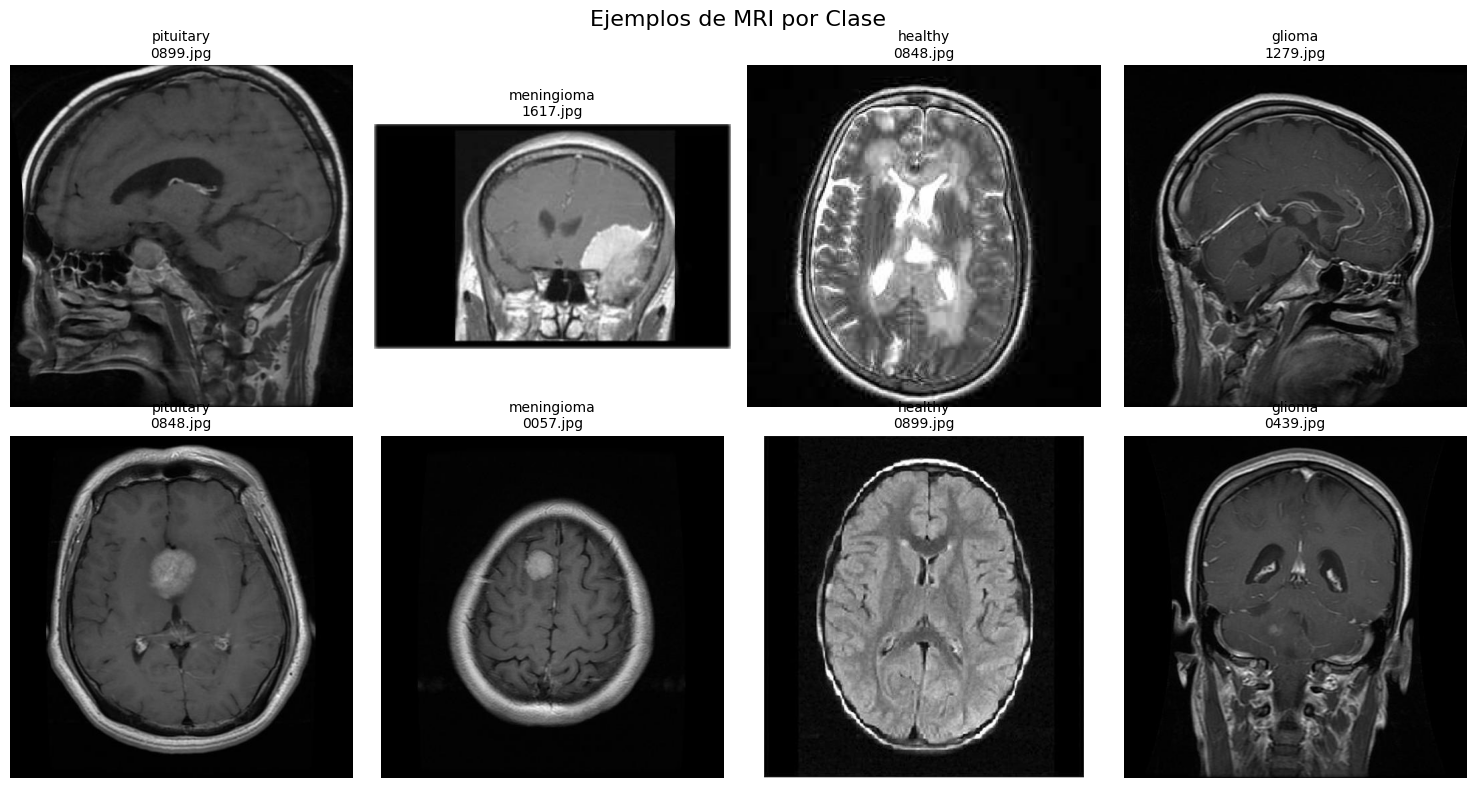

Shape de algunas imágenes:
pituitary: (512, 512) - Modo: RGB
meningioma: (440, 278) - Modo: RGB
healthy: (228, 221) - Modo: RGB
glioma: (512, 512) - Modo: RGB


In [6]:
# Imports
import os
from PIL import Image
import matplotlib.pyplot as plt
# Carpeta temporal
data_dir = "/root/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1"

print("Mismas clases anteriormente encontradas:", os.listdir(data_dir))

#Loop accediendo a cada folder
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        # Impresión de cantidad de imágenes y print de nombres de algunos ejemplos
        print(f"{folder}: {num_images} imágenes")
        print(f"  Ejemplos: {os.listdir(folder_path)[:3]}")
        print()
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Ejemplos de MRI por Clase', fontsize=16)


# Ploteo de las imagenes de cada dir (2 cada una)

folders = os.listdir(data_dir)
for idx, folder in enumerate(folders):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        
        for i in range(2):
            if i < len(images):
                img_path = os.path.join(folder_path, images[i])
                img = Image.open(img_path)
                
                row = i
                col = idx
                axes[row, col].imshow(img, cmap='gray')
                axes[row, col].set_title(f'{folder}\n{images[i]}', fontsize=10)
                axes[row, col].axis('off')

plt.tight_layout()
plt.show()

#Shape de algunas imagenes
print("Shape de algunas imágenes:")
for folder in folders:
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        img_path = os.path.join(folder_path, os.listdir(folder_path)[0])
        img = Image.open(img_path)
        print(f"{folder}: {img.size} - Modo: {img.mode}")

## Carga de datos

In [7]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

#Función para cargar los datos
def load_data(data_dir):
    """
    Carga y divide el dataset de MRI en train/val/test con ratio ~80-10-10.
    Imágenes en RGB, resize a (255,255), valores 0-255 (uint8) y etiquetas one-hot.
    """
    image_paths = []
    labels = []
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                # Fallback por si no existen solo jpg sino jpeg o png
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(class_dir, img_file))
                    labels.append(class_name)
    # Encoder de categorías
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_onehot = to_categorical(labels_encoded)
    # Subset - Entrenamiento, Validación y Testing
    train_paths, temp_paths, y_train, y_temp = train_test_split(
        image_paths, labels_onehot, test_size=0.2, stratify=labels_encoded, random_state=77
    )
    val_paths, test_paths, y_val, y_test = train_test_split(
        temp_paths, y_temp, test_size=0.5, stratify=np.argmax(y_temp, axis=1), random_state=77
    )
    # Carga de imagenes en 3 canales
    def load_image(path):
        img = Image.open(path).convert('RGB')
        img = img.resize((100, 100))
        return np.array(img) # 255 - uint8
    
    X_train = np.array([load_image(p) for p in train_paths])
    X_val = np.array([load_image(p) for p in val_paths])
    X_test = np.array([load_image(p) for p in test_paths])
    # División por 255
    X_train = X_train / 255.0
    X_val = X_val / 255.0
    X_test = X_test / 255.0
    
    print(f'Conjunto de datos cargados')
    print(f'Tamaño X_train {X_train.shape}, y_train {y_train.shape}')
    print(f'Tamaño X_val {X_val.shape}, y_val {y_val.shape}')
    print(f'Tamaño X_test {X_test.shape}, y_test {y_test.shape}')
    print(f'Datos por etiqueta en train: {np.bincount(np.argmax(y_train, axis=1))}')
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test = load_data(data_dir)

Conjunto de datos cargados
Tamaño X_train (5618, 100, 100, 3), y_train (5618, 4)
Tamaño X_val (702, 100, 100, 3), y_val (702, 4)
Tamaño X_test (703, 100, 100, 3), y_test (703, 4)
Datos por etiqueta en train: [1297 1600 1316 1405]


## Modelo

# Imports de Keras: Sequential, Input, Dense, Conv2D, MaxPooling2D, Flaten y DropOut


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten,Dropout

def load_model():
    """
    Esta función construye un modelo neuronal convolucional para el problema de clasificación del MRI dataset
    """
    model = Sequential()
    # input
    model.add(Input(shape=(100, 100, 3), name='Entrada'))
    # Primera capa convolucional Kernel de 5x5 y 50 filtros
    model.add(Conv2D(50, (5, 5), activation='relu', padding='same', name='PrimeraConv2D'))
    # Capa de MaxPooling
    model.add(MaxPooling2D(pool_size=(2, 2), name='PrimeraMaxPooling2D'))
    model.add(Flatten(name='Aplanado'))
    
    # Capa final densa antes de la salida
    model.add(Dense(45, activation='gelu', name='CapaFinalDensa'))
    # Capa de salida con 4 categorías
    model.add(Dense(4, activation='softmax', name='Output'))
    return model

La arquitectura propuesta recibe entradas de dimensión (100, 100, 3) y está compuesta por una capa convolucional 2D con 25 filtros de tamaño 5×5, seguida de una capa de MaxPooling 2D con una ventana de 2×2, una capa de aplanado, una capa densa intermedia de 25 neuronas con activación ReLU, y una capa de salida Softmax con cuatro neuronas correspondientes a las clases objetivo.

Se plotea acá abajo:

In [10]:
model = load_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 PrimeraConv2D (Conv2D)      (None, 100, 100, 50)      3800      
                                                                 
 PrimeraMaxPooling2D (MaxPoo  (None, 50, 50, 50)       0         
 ling2D)                                                         
                                                                 
 Aplanado (Flatten)          (None, 125000)            0         
                                                                 
 CapaFinalDensa (Dense)      (None, 45)                5625045   
                                                                 
 Output (Dense)              (None, 4)                 184       
                                                                 
Total params: 5,629,029
Trainable params: 5,629,029
Non-trainable params: 0
______________________________________________

### Compilación y entrenamiento

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Recall

set_seed(77)
model = load_model()

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

optimizer = SGD(learning_rate=0.0099, momentum=0.9)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', Recall(name='recall')]
)

resultsFit = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    callbacks=[early_stop],
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/20
352/352 [==============================] - 31s 44ms/step - loss: 0.6735 - accuracy: 0.7296 - recall: 0.6362 - val_loss: 0.4519 - val_accuracy: 0.7949 - val_recall: 0.7835
Epoch 2/20
352/352 [==============================] - 2s 6ms/step - loss: 0.3525 - accuracy: 0.8597 - recall: 0.8466 - val_loss: 0.3368 - val_accuracy: 0.8818 - val_recall: 0.8675
Epoch 3/20
352/352 [==============================] - 2s 5ms/step - loss: 0.2174 - accuracy: 0.9176 - recall: 0.9133 - val_loss: 0.3135 - val_accuracy: 0.8846 - val_recall: 0.8761
Epoch 4/20
352/352 [==============================] - 2s 5ms/step - loss: 0.1490 - accuracy: 0.9452 - recall: 0.9438 - val_loss: 0.2739 - val_accuracy: 0.9188 - val_recall: 0.9145
Epoch 5/20
352/352 [==============================] - 2s 5ms/step - loss: 0.1140 - accuracy: 0.9624 - recall: 0.9605 - val_loss: 0.2420 - val_accuracy: 0.9245 - val_recall: 0.9188
Epoch 6/20
352/352 [==============================] - 2s 5ms/step - loss: 0.0462 - accuracy: 0.983

# Compilación y entrenar el modelo

## Resultados

In [12]:
#Reutilización de función de ploteo de historia:

def visualization_history(resultsFit):
    """
    Esta función grafica las curvas de precisión a lo largo de las épocas de entrenamiento
    para el conjunto de prueba como el de validación.
    Parámetros:
    resultsFit = historial de entrenamiento de un modelo entensorflow.keras
    Salida:
    Gráfica de la precisión en validación y prueba.
    """
    # Llamado al entrono de la gráfica y fijar tamaño de visualización
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    # Graficar la presición de la historia en entrenamiento
    axes[0].plot(range(len(resultsFit.history['accuracy'])), resultsFit.history['accuracy'],
           '#5a2ff4', linestyle = "-", marker = "o",
           label='Precisión entrenamiento', lw = 3)

    # Graficar la presición de la historia en validación
    axes[0].plot(range(len(resultsFit.history['val_accuracy'])), resultsFit.history['val_accuracy'],  '#60d13e',
           label='Precisión validación', linestyle = '-', marker = 'o', lw = 3)
    
    # Umbral 90% de precisión 
    axes[0].plot(range(len(resultsFit.history['val_accuracy'])), 0.9*np.ones(len(resultsFit.history['val_accuracy'])), 
               'red', lw = 3, label = 'Umbral')
               
    # Títulos de los ejes
    axes[0].set_xlabel('Época',fontsize=16)
    axes[0].set_ylabel(r'Precisión',fontsize=16)
    axes[0].set_ylim(top=1) # Límite de la grafica
    axes[0].grid()      # Activar la cuadricula
    axes[0].legend(fontsize=14,loc = 'lower right')   # Establecer la legenda


    # Graficar la pérdida de la historia en entrenamiento
    axes[1].plot(range(len(resultsFit.history['loss'])), resultsFit.history['loss'],
           '#5a2ff4', linestyle = "-", marker = "o",
           label='Pérdida entrenamiento', lw = 3)

    # Graficar la presición de la historia en validación
    axes[1].plot(range(len(resultsFit.history['val_loss'])), resultsFit.history['val_loss'],  '#60d13e',
           label='Pérdida validación', linestyle = '-', marker = 'o', lw = 3)

    # Títulos de los ejes
    axes[1].set_xlabel('Época',fontsize=16)
    axes[1].set_ylabel(r'Pérdida',fontsize=16)
    axes[1].grid()      # Activar la cuadricula
    axes[1].legend(fontsize=14,loc = 'upper right')   # Establecer la legenda


    plt.tight_layout() # Ajusta automáticamente el diseño de la figura
    plt.show()

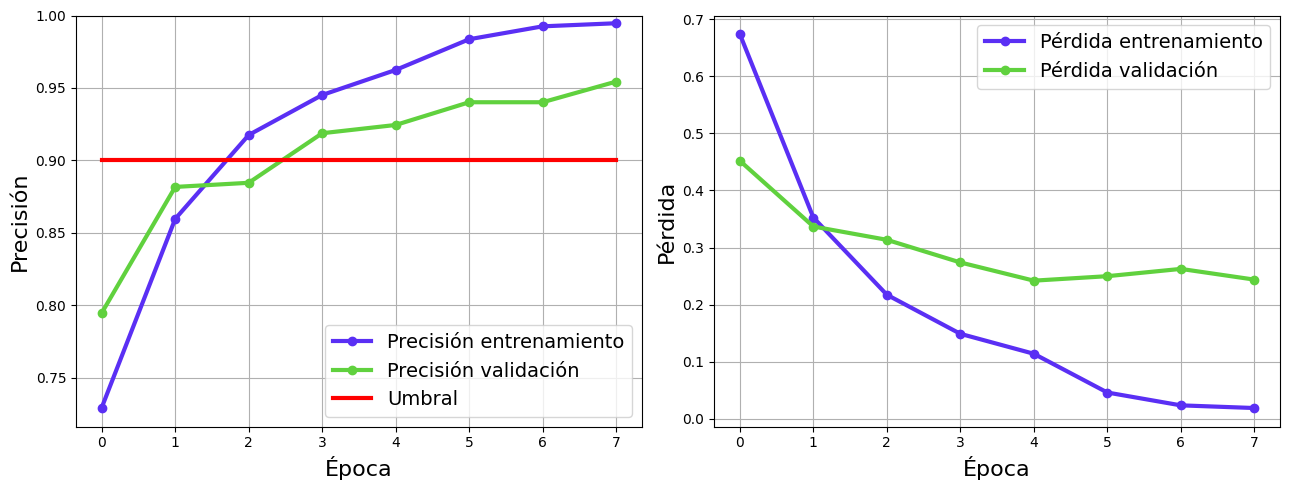

In [13]:
visualization_history(resultsFit)

22/22 [==============================] - 0s 3ms/step
REPORTE DE CLASIFICACIÓN POR CATEGORÍA
              precision    recall  f1-score   support

  meningioma       0.91      0.91      0.91       162
     healthy       0.97      0.95      0.96       200
      glioma       0.85      0.88      0.87       165
   pituitary       0.98      0.97      0.98       176

    accuracy                           0.93       703
   macro avg       0.93      0.93      0.93       703
weighted avg       0.93      0.93      0.93       703


MATRIZ DE CONFUSIÓN
[[148   0  14   0]
 [  0 191   7   2]
 [ 13   5 146   1]
 [  1   0   4 171]]


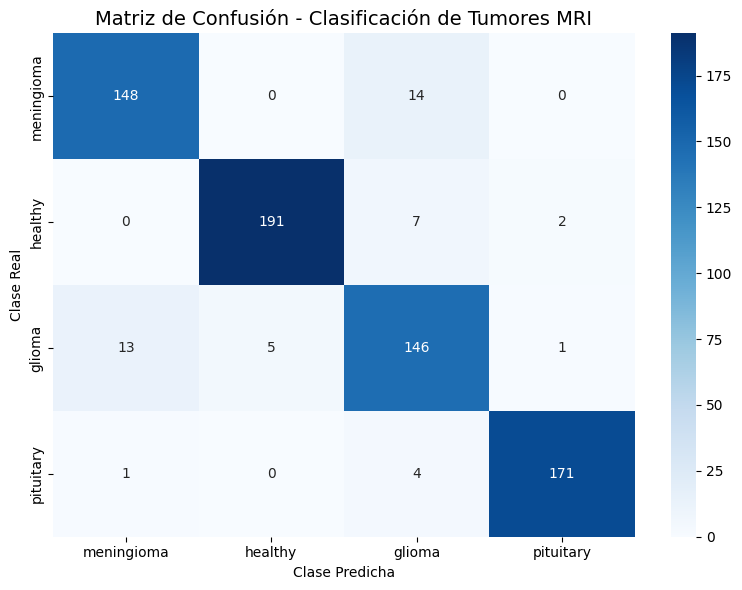


ACCURACY POR CLASE
meningioma: 91.36% (148/162)
healthy: 95.50% (191/200)
glioma: 88.48% (146/165)
pituitary: 97.16% (171/176)

CONFUSIONES MÁS FRECUENTES
meningioma clasificado como glioma: 14 casos
healthy clasificado como glioma: 7 casos
healthy clasificado como pituitary: 2 casos
glioma clasificado como meningioma: 13 casos
glioma clasificado como healthy: 5 casos
glioma clasificado como pituitary: 1 casos
pituitary clasificado como meningioma: 1 casos
pituitary clasificado como glioma: 4 casos


In [14]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

class_names = ['meningioma', 'healthy', 'glioma', 'pituitary'] 

print("="*60)
print("REPORTE DE CLASIFICACIÓN POR CATEGORÍA")
print("="*60)
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# 4. CM
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("\n" + "="*60)
print("MATRIZ DE CONFUSIÓN")
print("="*60)
print(cm)

# 5. Viz
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Matriz de Confusión - Clasificación de Tumores MRI', fontsize=14)
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.tight_layout()
plt.show()

# 6. Acc
print("\n" + "="*60)
print("ACCURACY POR CLASE")
print("="*60)
for i, class_name in enumerate(class_names):
    class_acc = cm[i, i] / cm[i].sum()
    print(f"{class_name}: {class_acc*100:.2f}% ({cm[i, i]}/{cm[i].sum()})")

# 7. Errores
print("\n" + "="*60)
print("CONFUSIONES MÁS FRECUENTES")
print("="*60)
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:
            print(f"{class_names[i]} clasificado como {class_names[j]}: {cm[i, j]} casos")

## Mapas de Características propagados

Se usan dos funciones principalmente

1. `gradcam`: Mapa de activación de clase ponderada por gradiente (Grad - CAM) que detalla en un mapa de calor las regiones que una red neuronal convolucional está detallando más al momento de hacer una predicción. 

2. `show_gradcam`: La función de visualización del mapeo GradCAM.

1/1 [==============================] - 0s 25ms/step


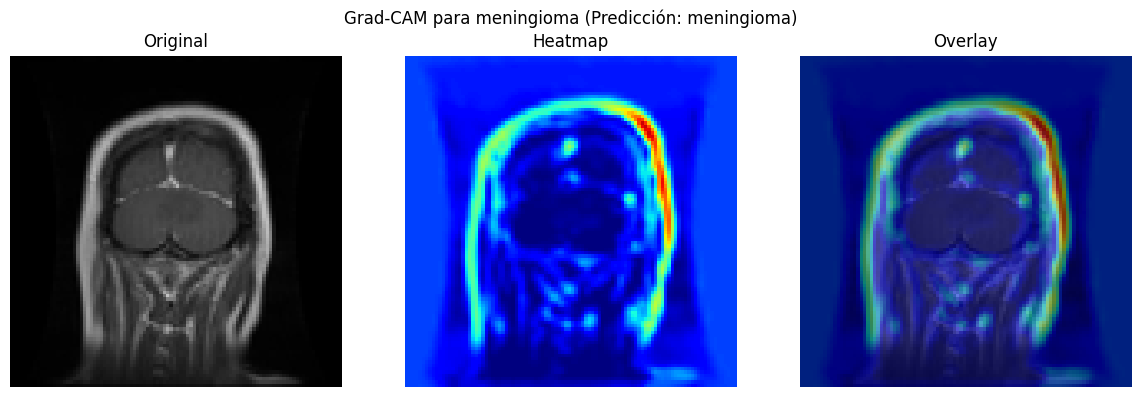

1/1 [==============================] - 0s 23ms/step


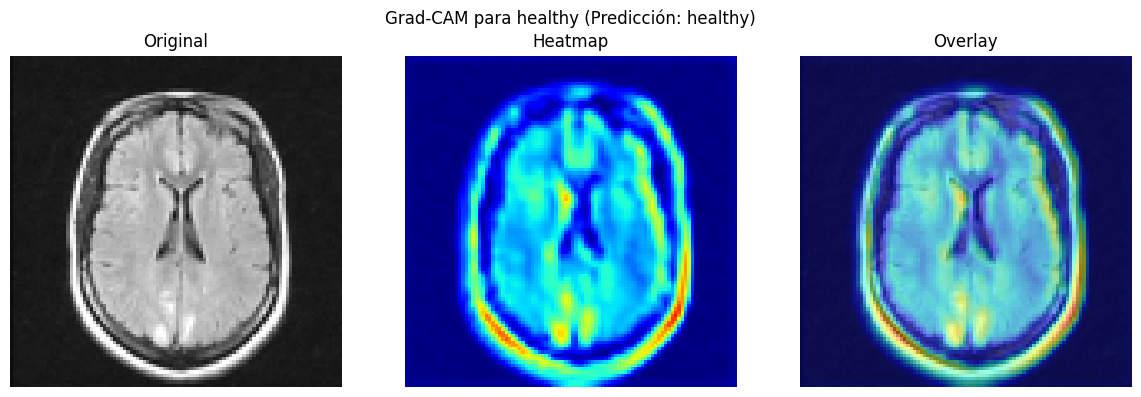

1/1 [==============================] - 0s 31ms/step


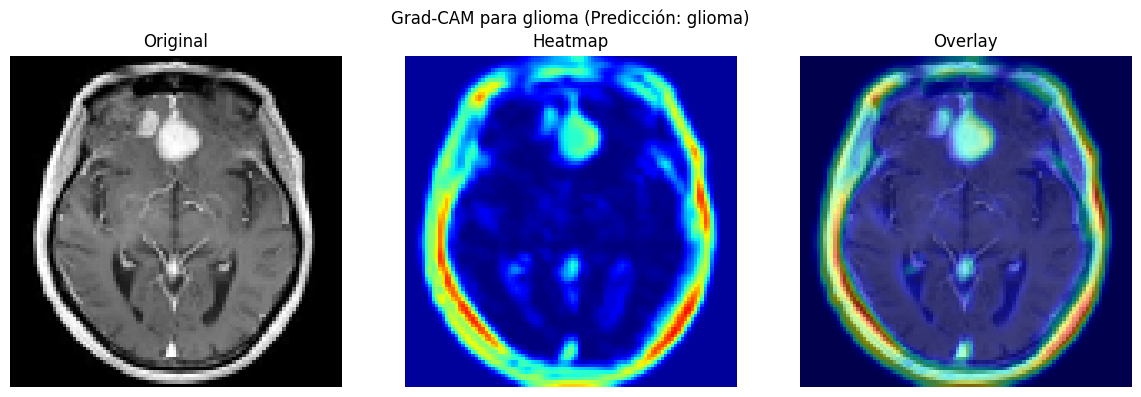

1/1 [==============================] - 0s 30ms/step


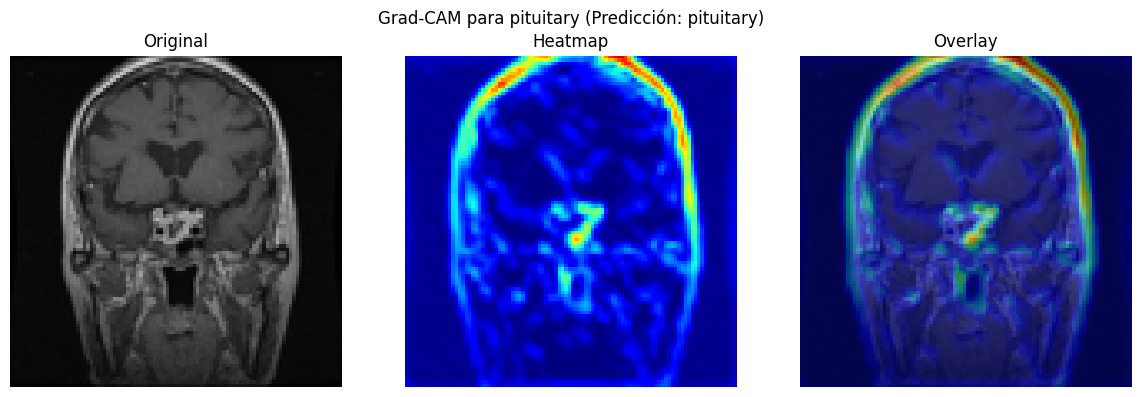

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# ---------------------- GradCAM ----------------------------
def gradcam(model, image, class_idx=None, layer_name=None):
    if layer_name is None:
        for layer in reversed(model.layers):
            if len(layer.output.shape) == 4:
                layer_name = layer.name
                break
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Calcula gradientes respecto a la clase deseada
    with tf.GradientTape() as tape:
        inputs = tf.cast(image, tf.float32)
        conv_outputs, predictions = grad_model(inputs)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)

    # Guided Grad-CAM: se enfoca en gradientes positivos
    guided_grads = tf.cast(conv_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads

    # Promedio de gradientes (peso por canal RGB)
    weights = tf.reduce_mean(guided_grads, axis=(0, 1, 2))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs[0]), axis=-1)

    # ReLU y normalización
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)

    # Redimensiona al tamaño de la imagen original
    h, w = image.shape[1:3]
    cam = tf.image.resize(cam[..., tf.newaxis], (h, w)).numpy()
    cam = (cam[:, :, 0] * 255).astype("uint8")

    return cam


#----------------- Visualización GradCAM -------------------------------
def show_gradcam(original_image, heatmap, class_name, pred_name, alpha=0.5):
    # Aplica colormap jet para mejor visualización azul - rojo
    colormap = cm.get_cmap('jet')
    colored_heatmap = colormap(heatmap / 255.0)[:, :, :3]

    # Overlay con la imagen original
    if np.max(original_image) > 1:
        original_image = original_image / 255.0
    overlay = alpha * colored_heatmap + (1 - alpha) * original_image
    overlay = np.clip(overlay, 0, 1)

    # Mostrar todo
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f"Grad-CAM para {class_name} (Predicción: {pred_name})")

    axes[0].imshow(original_image)
    axes[0].set_title("Original")
    axes[1].imshow(colored_heatmap)
    axes[1].set_title("Heatmap")
    axes[2].imshow(overlay)
    axes[2].set_title("Overlay")
    for ax in axes: ax.axis('off')

    plt.tight_layout()
    plt.show()


#C Clases originales
class_names = {0: 'meningioma', 1: 'healthy', 2: 'glioma', 3: 'pituitary'}

# GradCam para cada clase
y_val_labels = np.argmax(y_val, axis=1)
num_classes = 4

for class_idx in range(num_classes):
    class_name = class_names.get(class_idx, f'Clase {class_idx}')
    indices = np.where(y_val_labels == class_idx)[0]
    selected_idx = None
    for idx in indices:
        pred = np.argmax(model.predict(np.expand_dims(X_val[idx], 0))[0])
        if pred == class_idx:
            selected_idx = idx
            break
    image = np.expand_dims(X_val[selected_idx], 0)
    pred = model.predict(image)
    pred_idx = np.argmax(pred[0])
    pred_name = class_names.get(pred_idx, f'Clase {pred_idx}')

    # Grad-CAM PrimeraConv2D PrimeraMaxPooling2D
    heatmap = gradcam(model, image, class_idx=class_idx, layer_name='PrimeraMaxPooling2D')

    # Visualiza
    show_gradcam(X_val[selected_idx], heatmap, class_name, pred_name)
